## 变分量子回归模型简介
*Copyright (c) 2022 Institute for Quantum Computing, Baidu Inc. All Rights Reserved.*

回归分析（regression analysis）是一种用于估计因变量和一个或多个自变量间相互依赖的定量关系的统计分析方法。回归分析根据自变量的多少，可以分为一元回归和多元回归；根据自变量和因变量间的关系类型，可以分为线性回归和非线性回归。回归分析被广泛应用于预测及推断变量间的因果关系（如预测人口增长趋势），对各学科领域的发展起到重要推动作用。

变分量子回归（variational quantum regression, VQR）是一个在监督学习框架下的量子-经典混合算法。VQR 结合了经典与量子的优势，通过将数据编码为量子态，经过量子电路的演化，再结合经典机器学习中的优化算法（如梯度下降法）不断调整参数使得损失函数最小化，从而得到拟合函数。

本教程首先介绍了 VQR 的原理，接着展示了利用量桨进行线性回归和高阶多项式回归的效果，最后介绍了如何利用量桨实现 VQR。

## 模型原理简介

以多项式函数拟合为例，其训练步骤主要可以分为：**输入** -> **信息预处理** -> **优化迭代** -> **输出**，四个主要部分。用户只需输入所需回归分析的经典数据集（为 ``.csv`` 文件）以及想要拟合的函数的阶 $k$。VQR 模型将初始化相应模型，
$$y = c_0 + c_1x^1 + c_2 x^2 + \cdots + c_k x^k，$$
同时自动将经典数据集融合迭代参数（也就是多项式系数 $\bm{c}$）输入进量子设备并进行算法优化迭代，直到损失函数收敛。输出完成优化的参数 $\bm{c}^*$ 以及相应的模型，以便后续使用。

VQR 流程图如下：

![flowchart](./fig/flowchart_CN.png "图1：变分量子回归流程图。")
<div style="text-align:center">VQR 流程图</div>

## 模型效果

我们通常采用均方误差（mean squared error, MSE）、平均绝对误差（mean absolute error, MAE）和可决系数（R-squared）来评价回归效果，其中 MSE 可以评价数据的变化程度，MSE 越小，说明拟合函数在预测数据上具有更好的精确度；MAE 反映预测值误差的实际情况，MAE 越小，说明拟合效果越好；可决系数衡量了回归函数整体的拟合度，越接近于 $1$ 说明拟合效果越好。

利用量桨拟合简单的线性函数和三阶多项式函数效果图如下，可以看到两者的可决系数都接近于 $1$，说明拟合效果较好。

![LR](./fig/Evaluation_Index.png "拟合效果图")
拟合效果图：(a) 图表示拟合线性函数 $y=x+c_1$ 的效果图（$c_1$ 为属于 $[-1,1)$ 的噪声）；(b) 图表示拟合多项式函数 $y=(2x-1)^3+c_2$ 的效果图（$c_2$ 为属于 $[-1,1)$ 的噪声）；(c) 图为拟合效果评价指标。

## 模型演示

我们已经给出了两个设置好的参数，可以直接用于线性和多项式回归分析。只需要在 `linear.toml` 和 `poly.toml` 配置文件中进行对应的配置，然后输入命令 `python vqr_analysis.py --config linear(poly).toml` 即可进行线性或多项式变分量子回归。

这里我们利用 VQR 进行 `poly` 模型演示来拟合不同种类鱼的重量和宽度之间的关系，其中将鱼的宽度设置为自变量 $x$，重量设置为因变量 $y$。首先按照如下代码来配置环境：

In [1]:
# 安装量桨
# %pip install paddle-quantum

In [2]:
poly_toml = r"""
# 模型的整体配置文件。
# 输入当前的任务，可以是 'linear' 或者 'poly', 分别代表线性和多项式回归。这里我们使用 poly, 进行回归分析。
# 用于分析的模型类型。
model_name = 'poly'
# 要分析的 .csv 文件路径。
data_file = './datasets/Fish.csv'
# 需要分析的自变量数据名称 List。
x_feature = ['Width']
# 因变量数据名称。
y_feature = ['Weight']
# 所需优化参数量。对于线性回归模型，其值等于自变量数量；对于多项式模型，其值代表多项式阶数。
num_variable = 3
# 初始优化参数值。参数数量需等于 num_variable + 1。
init_params = [0.0, 0.45, 0.5, 0.5]
# 所需量子比特数。默认为 6。
num_qubits = 6
# 优化过程学习率。默认为 0.1。
learning_rate = 0.1
# 优化总迭代步数。默认为 100。
iteration = 100
# 打印的语言。默认为 'CN'。
language = 'CN'
"""

量桨 PaddleQuantum 的数据处理模块存有量子数据处理工具。我们可以从 `paddle_quantum.data_analysis.vqr` 模块里导入 `QRegressionModel` 来进行数据的回归分析。

In [6]:
# 导入所需要的包
import os
import warnings
import toml

warnings.filterwarnings('ignore')
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

import paddle_quantum as pq
from paddle_quantum.data_analysis.vqr import QRegressionModel
poly_config = toml.loads(poly_toml)

pq.set_backend("state_vector")
pq.set_dtype("complex128")

### 高阶多项式回归

In [4]:
# 初始化回归模型
poly_model = QRegressionModel(**poly_config)

模型是否被训练：False。当前模型 R2 得分：-0.51802。
拟合后的模型为：Weight = 0.00000 + (0.45000*Width^1) + (0.50000*Width^2) + (0.50000*Width^3)。


100%|##########| 100/100 [00:02<00:00, 43.36it/s]


模型是否被训练：True。当前模型 R2 得分：0.74693。
拟合后的模型为：Weight = -0.04323 + (1.20800*Width^1) + (1.83084*Width^2) + (2.22695*Width^3)。


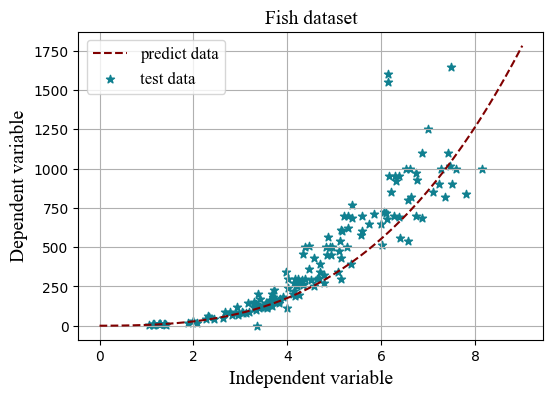

In [5]:
# 模型训练和结果
fitted_poly_estimator = poly_model.regression_analyse()

通过修改配置文件的内容，并运行分析代码，即可在线对模型进行测试。

## 注意事项

模型的最终训练效果与初始参数的选取有很大的关系，实际情形下需要考虑不同初始参数的情形以达到最好的拟合效果。

## 引用信息

```
@article{bravo2019variational,
  title={Variational quantum linear solver},
  author={Bravo-Prieto, Carlos and LaRose, Ryan and Cerezo, Marco and Subasi, Yigit and Cincio, Lukasz and Coles, Patrick J},
  journal={arXiv preprint arXiv:1909.05820},
  year={2019}
}
```

```
@article{chicco2021coefficient,
  title={The coefficient of determination R-squared is more informative than SMAPE, MAE, MAPE, MSE and RMSE in regression analysis evaluation},
  author={Chicco, Davide and Warrens, Matthijs J and Jurman, Giuseppe},
  journal={PeerJ Computer Science},
  volume={7},
  pages={e623},
  year={2021},
  publisher={PeerJ Inc.}
}
```

## 参考文献

[1] Bravo-Prieto, Carlos, et al. "Variational quantum linear solver." arXiv preprint arXiv:1909.05820 (2019).

[2] Chicco, Davide, Matthijs J. Warrens, and Giuseppe Jurman. "The coefficient of determination R-squared is more informative than SMAPE, MAE, MAPE, MSE and RMSE in regression analysis evaluation." PeerJ Computer Science 7 (2021): e623.